In [7]:
%matplotlib inline
import numpy as np
from pylab import *
import pyxrt
from craft import uvfits
from craft.craco_plan import PipelinePlan
from craco_testing.pyxrtutil import *


In [8]:
from craco.test_pipeline import location2pix, Pipeline
import craco

In [11]:
xclbin = '/data/craco/den15c/craco-python/src/craco/binary_container_1.xclbin.golden'
xclbin = '/data/craco/ban115/builds/binary_container_7630dd1f.xclbin'
fits = '../src/craco/frb_d0_lm0_nt16_nant24.fits'

In [12]:
device = pyxrt.device(0)
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)


In [13]:
fdmtcu = craco.test_pipeline.FdmtCu(device, xbin)

Kernel fdmt_tunable_c32:fdmt_tunable_c32_1 has groups
GID=0=52
GID=1=32
GID=2=53
GID=3=53
GID=4=14


In [14]:
f = uvfits.open(fits)
plan = PipelinePlan(f, craco.test_pipeline.get_parser().parse_args(''))

In [15]:
import craco_pybind11 as m
inbuf_shape = (m.krnl.NUREST, m.krnl.NT, m.fdmt_tunable.NCIN, m.krnl.NUVWIDE, 2)
mainbuf_shape = [m.krnl.NUREST, m.fdmt_tunable.NDOUT, m.fdmt_tunable.NTBLK_OUTBUF, m.krnl.NT, m.krnl.NUVWIDE, 2]
hist_shape = (m.krnl.NUREST, m.fdmt_tunable.HISTORY_SIZE, m.krnl.NUVWIDE, 2)
config_shape = (m.krnl.NUREST, m.fdmt_tunable.CONFIG_STREAM_DEPTH, m.krnl.NUVWIDE, 2)
nuv = m.krnl.MAX_NSMP_UV

In [16]:
inbuf = Buffer(inbuf_shape, np.int16, device, fdmtcu.krnl.group_id(0)).clear()


Allocated 268173312 bytes flags=flags.normal groupid=52 address=0x90000000


In [17]:
fdmt_hist_buf = Buffer(hist_shape,  np.int16, device, fdmtcu.krnl.group_id(2)).clear()

Allocated 723727488 bytes flags=flags.normal groupid=53 address=0xa0000000


In [18]:
fdmt_config_buf = Buffer(config_shape, np.uint16, device, fdmtcu.krnl.group_id(4)).clear()

Allocated 1014816 bytes flags=flags.normal groupid=14 address=0xe0000000


In [19]:
all_mainbufs = []
for b in range(8):
    mainbuf_shape[0] = 128
    mainbuf = Buffer(mainbuf_shape, np.int16, device, fdmtcu.krnl.group_id(1)).clear()
    all_mainbufs.append(mainbuf)

Allocated 2145386496 bytes flags=flags.normal groupid=32 address=0x4000000000
Allocated 2145386496 bytes flags=flags.normal groupid=32 address=0x407fe00000
Allocated 2145386496 bytes flags=flags.normal groupid=32 address=0x40ffc00000
Allocated 2145386496 bytes flags=flags.normal groupid=32 address=0x417fa00000
Allocated 2145386496 bytes flags=flags.normal groupid=32 address=0x41ff800000
Allocated 2145386496 bytes flags=flags.normal groupid=32 address=0x427f600000
Allocated 2145386496 bytes flags=flags.normal groupid=32 address=0x42ff400000
Allocated 2145386496 bytes flags=flags.normal groupid=32 address=0x437f200000


In [20]:
addresses = np.array([b.buf.address() for b in all_mainbufs])
print(addresses)
print(addresses[1:] - addresses[:-1])

[274877906944 277023293440 279168679936 281314066432 283459452928
 285604839424 287750225920 289895612416]
[2145386496 2145386496 2145386496 2145386496 2145386496 2145386496
 2145386496]


In [21]:
channels = np.zeros((nuv), dtype=np.int32)
tblk = 0

In [22]:
m.fdmt_tunable.fdmt_calc_config(fdmt_config_buf.nparr, channels)


In [23]:
inbuf.nparr[...,0] = 1
inbuf.copy_to_device()
fdmt_config_buf.copy_to_device()
fdmtcu(inbuf, mainbuf, fdmt_hist_buf, fdmt_hist_buf, fdmt_config_buf, mainbuf_shape[0], tblk).wait(0)
mainbuf.copy_from_device()

In [24]:
print(mainbuf.nparr.shape)

(128, 186, 11, 256, 8, 2)


Text(0, 0.5, 'dm')

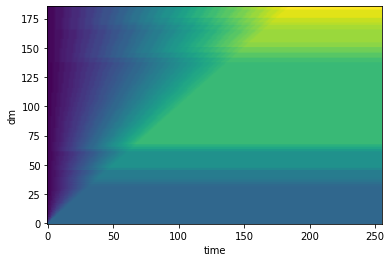

In [25]:
imshow(mainbuf.nparr[0,:,0,:,0,0], aspect='auto', origin='lower')
xlabel('time')
ylabel('dm')

In [26]:
print(fdmt_config_buf.nparr.shape)
print(plan.fdmt_plan.fdmt_lut.shape)

(1023, 31, 8, 2)
(802, 31, 8, 2)


In [27]:
print(fdmt_config_buf.nparr[0,0,:,:])
print(plan.fdmt_plan.fdmt_lut[0,0,:,:])

[[16431 49198]
 [16431 49198]
 [16431 49198]
 [16431 49198]
 [16431 49198]
 [16431 49198]
 [16431 49198]
 [16431 49198]]
[[16421 49189]
 [16421 49189]
 [16421 49189]
 [16421 49189]
 [16421 49189]
 [16421 49189]
 [16421 49189]
 [16421 49189]]


In [28]:
plan.fdmt_plan.run_fch1


[999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 1003499994.1340001,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 999499993.944,
 1007499994.324,
 999499993.944,
 999499993.944,
 999499993.944,
 9

In [29]:
plan.foff

1000000.0475000143